<a href="https://colab.research.google.com/github/nihcas2015/SRIP_2025/blob/main/full_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost
!pip install imblearn



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression


from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, f1_score
%matplotlib inline
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])

In [ ]:
data.info()

In [ ]:
data.columns

In [ ]:
data=data.drop(columns=["pkSeqID","stime","flgs","proto","saddr","sport","daddr","dport","state","ltime","seq"])

In [ ]:
#dropping correlated columns
data=data.drop(columns=["bytes","max","spkts","sbytes","dbytes","AR_P_Proto_P_Dport","state_number","dpkts"])

In [ ]:
data=data.drop_duplicates()

In [ ]:
data.isnull().sum()

In [23]:
data['category'].value_counts()

,count
category,
0,1095618
1,872946
3,65886
2,433
4,75


In [24]:
data["attack"].value_counts()

,count
attack,
1,2034525
0,433


In [25]:
data["subcategory"].value_counts()

,count
subcategory,
7,1070967
6,895123
5,51314
4,14572
1,2474
3,433
2,69
0,6


In [8]:
le = LabelEncoder()
data['category'] = le.fit_transform(data['category'])
data['subcategory'] = le.fit_transform(data['subcategory'])
data.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1,8,7.056393,0.068909,0.068909,0.137818,0.000000,0.992008,0.566862,...,1.142970,1.12704,96,75,1.133720,770,602,1,1,1
1,1,2,2,0.000131,0.000131,0.000000,0.000131,0.000131,7633.588379,0.000000,...,0.003857,15267.20000,1,2,0.005142,2,6,1,1,1
2,1,1,8,7.047852,0.064494,0.064494,0.128988,0.000000,0.993210,0.567549,...,1.142970,1.12704,96,75,1.135100,770,602,1,1,1
3,1,1,8,7.047592,0.064189,0.064189,0.128378,0.000000,0.993247,0.567570,...,1.142970,1.12704,96,75,1.135140,770,602,1,1,1
4,1,1,8,7.046841,0.063887,0.063887,0.127774,0.000000,0.993353,0.567630,...,1.142970,1.12704,96,75,1.135260,770,602,1,1,1


In [9]:
Y = data[['attack','category','subcategory']]
X= data.drop(['attack','category','subcategory'],axis=1)

In [ ]:
X.head()

In [11]:
mi_attack = mutual_info_classif(X, Y["attack"])
mi_subcat = mutual_info_classif(X, Y["subcategory"])
mi_cat    = mutual_info_classif(X, Y["category"])
mi_avg = (mi_attack + mi_subcat + mi_cat) / 3

df_mi = pd.DataFrame({
    'feature': X.columns.tolist(),
    'MI_attack': mi_attack,
    'MI_subcategory': mi_subcat,
    'MI_category': mi_cat,
    'MI_average': mi_avg
})

df_mi_sorted = df_mi.sort_values(by='MI_average', ascending=False)
top_features = df_mi_sorted.head(20)['feature'].tolist()
X = X[top_features]


In [ ]:
X.head()

In [12]:
model = XGBClassifier(tree_method='hist', n_jobs=-1)
model.fit(X, Y["attack"])

model1 = XGBClassifier(tree_method='hist', n_jobs=-1)
model1.fit(X, Y["subcategory"])

model2 = XGBClassifier(tree_method='hist', n_jobs=-1)
model2.fit(X, Y["category"])


importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features = importance_df['feature'].head(15)

importances = model1.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features1 = importance_df['feature'].head(15)

importances = model2.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features2 = importance_df['feature'].head(15)


combined_features = set(top_features) | set(top_features1) | set(top_features2)
X = X[list(combined_features)]

In [ ]:
X.head()

In [13]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [21]:
X_train.shape

(1627966, 19)

In [15]:
y_all = y_train[['attack', 'category', 'subcategory']].reset_index(drop=True)

# Apply SMOTE to only 'attack'
sm = SMOTE(k_neighbors=3, random_state=42)
X_resampled, y_attack_resampled = sm.fit_resample(X_train, y_all['attack'])

# Find how many synthetic rows were added
n_original = len(X_train)
n_total = len(X_resampled)
n_synthetic = n_total - n_original

# Get encoded label for "Normal"
normal_cat = le.transform(["Normal"])[0]
normal_subcat = le.transform(["Normal"])[0]

# Fill category and subcategory
y_category_resampled = pd.concat([
    y_all['category'],
    pd.Series([normal_cat] * n_synthetic)
], ignore_index=True)

y_subcategory_resampled = pd.concat([
    y_all['subcategory'],
    pd.Series([normal_subcat] * n_synthetic)
], ignore_index=True)

# Final combined labels
y_train_resampled = pd.DataFrame({
    "attack": y_attack_resampled,
    "category": y_category_resampled,
    "subcategory": y_subcategory_resampled
})

# Replace original training data
X_train = X_resampled
y_train = y_train_resampled



In [22]:
X_train.shape

(3255238, 20)

In [ ]:
class RandomForest:
    def __init__(self,max_depth):
        self.rfc_attack = RandomForestClassifier(max_depth=max_depth)
        self.rfc_category = RandomForestClassifier(max_depth=max_depth)
        self.rfc_subcategory = RandomForestClassifier(max_depth=max_depth)

    def fit(self,X_train,y_train):
        self.rfc_attack.fit(X_train,y_train['attack'])

        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.rfc_category.fit(features_category,y_train['category'])

        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.rfc_subcategory.fit(features_subcategory,y_train['subcategory'])

    def predict(self,X_test):
        predict_attack = self.rfc_attack.predict(X_test)
        y_proba=self.rfc_attack.predict_proba(X_test)[:,1]
        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.rfc_category.predict(test_category)

        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.rfc_subcategory.predict(test_subcategory)



        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory,"y_proba":y_proba})

In [16]:
def display_metrics(y_true, y_pred, title,y_proba=None):
  print(f"--- {title} ---")
  print("\nClassification Report:")
  report = classification_report(y_true, y_pred, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print(df[:-3])

  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(f"Confusion Matrix for {title}")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

  acc = accuracy_score(y_true, y_pred)
  print(f"\nAccuracy: {acc:.4f}")

    # Weighted F1 Score
  f1 = f1_score(y_true, y_pred, average='weighted')
  print(f"Weighted F1 Score: {f1:.4f}")

  if y_proba is not None:
        # Check if binary classification
        unique_classes = pd.Series(y_true).nunique()
        if unique_classes == 2:
            # ROC AUC
            roc_auc = roc_auc_score(y_true, y_proba)
            print(f"ROC AUC Score: {roc_auc:.4f}")

            # Precision-Recall AUC
            pr_auc = average_precision_score(y_true, y_proba)
            print(f"PR AUC Score: {pr_auc:.4f}")

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.grid(True)
            plt.show()

            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(y_true, y_proba)
            plt.figure()
            plt.plot(recall, precision, label=f"AP = {pr_auc:.2f}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve")
            plt.legend()
            plt.grid(True)
            plt.show()



**Random Forest**

In [ ]:
rf = RandomForest(max_depth=3)
rf.fit(X_train,y_train)

predictions_rfc = rf.predict(X_test)



AttributeError: 'RandomForest' object has no attribute 'predict_proba'

--- Attack Prediction ---

Classification Report:
   precision    recall  f1-score   support
0   0.273016  1.000000  0.428928      86.0
1   1.000000  0.999437  0.999719  406906.0


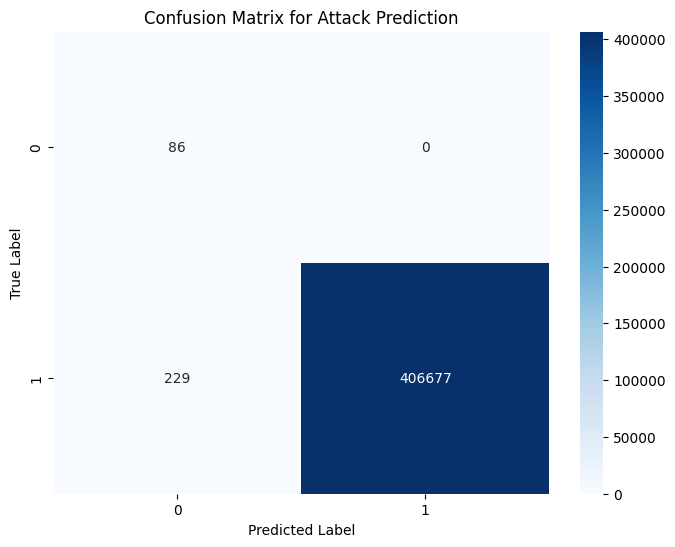


Accuracy: 0.9994
Weighted F1 Score: 0.9996
ROC AUC Score: 1.0000
PR AUC Score: 1.0000


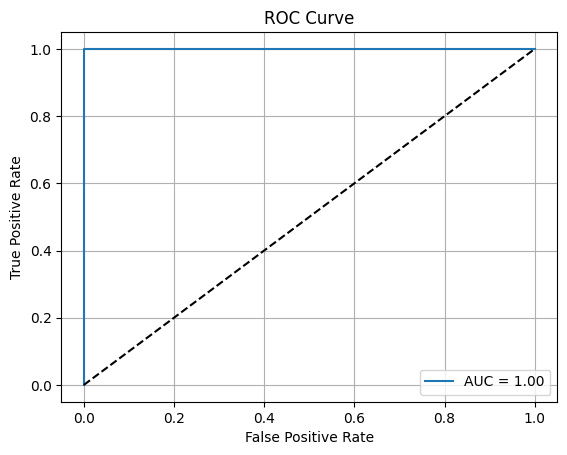

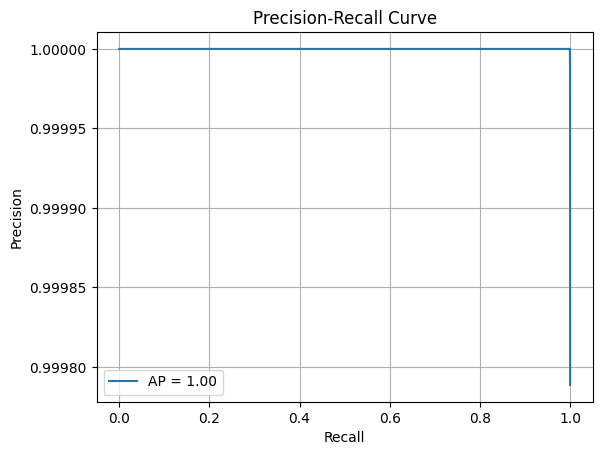

In [ ]:
display_metrics(y_test['attack'], predictions_rfc['attack'], "Attack Prediction",predictions_rfc["y_proba"])



--- Category Prediction ---

Classification Report:
   precision    recall  f1-score   support
0   0.993992  0.875144  0.930790  219124.0
1   0.878122  0.957289  0.915998  174590.0
2   0.152610  0.883721  0.260274      86.0
3   0.901161  0.954163  0.926905   13177.0
4   0.001615  1.000000  0.003225      15.0


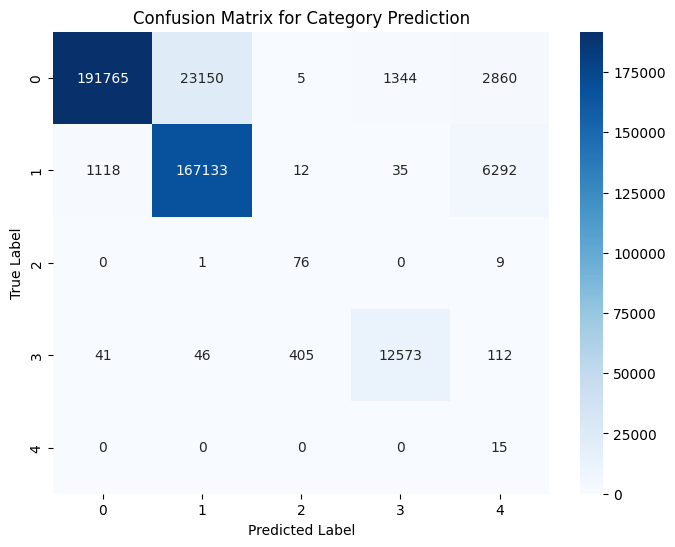


Accuracy: 0.9129
Weighted F1 Score: 0.9241


In [ ]:
display_metrics(y_test['category'], predictions_rfc['category'], "Category Prediction")


--- Subcategory Prediction ---

Classification Report:
   precision    recall  f1-score   support
0   0.004608  1.000000  0.009174       1.0
1   0.067614  0.961616  0.126344     495.0
2   0.001108  0.714286  0.002213      14.0
3   0.170478  0.953488  0.289242      86.0
4   0.275728  0.946122  0.427012    2914.0
5   0.983932  0.381857  0.550190   10263.0
6   0.998297  0.903952  0.948785  179025.0
7   0.999491  0.999253  0.999372  214194.0


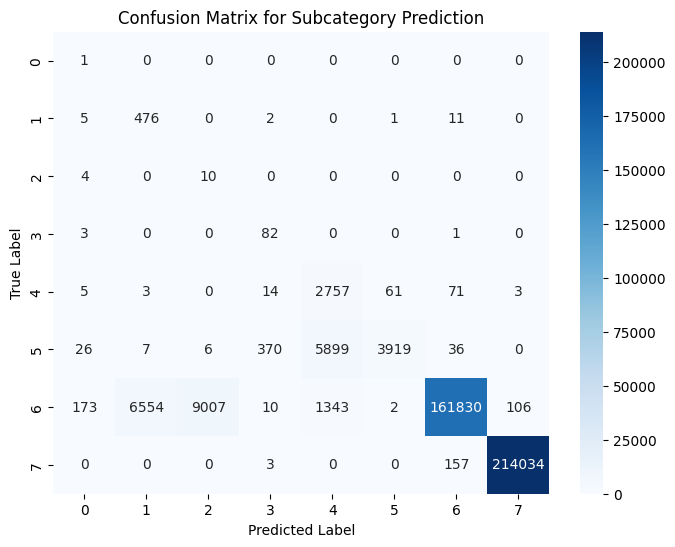


Accuracy: 0.9413
Weighted F1 Score: 0.9604


In [ ]:
display_metrics(y_test['subcategory'], predictions_rfc['subcategory'], "Subcategory Prediction")

XGB graddient boosting


In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["attack"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

y_proba = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:27:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Attack Prediction ---

Classification Report:
   precision    recall  f1-score   support
0   1.000000  0.988372  0.994152      86.0
1   0.999998  1.000000  0.999999  406906.0


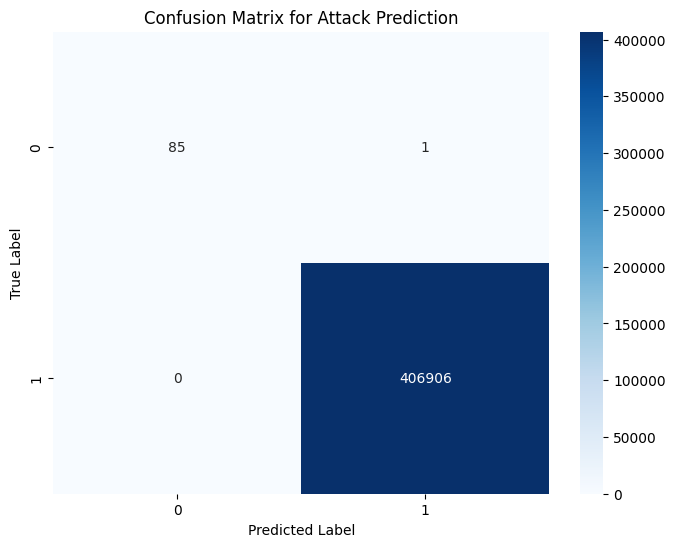


Accuracy: 1.0000
Weighted F1 Score: 1.0000
ROC AUC Score: 1.0000
PR AUC Score: 1.0000


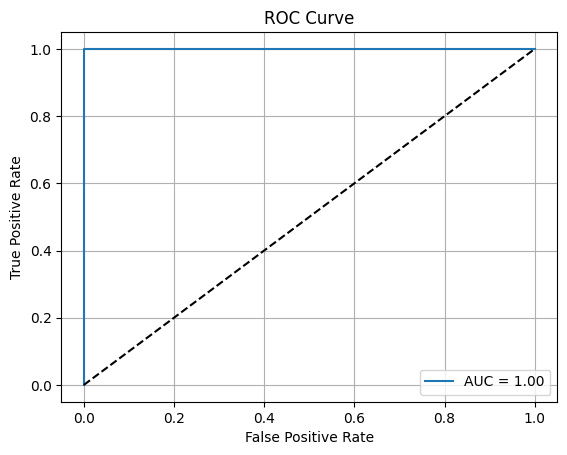

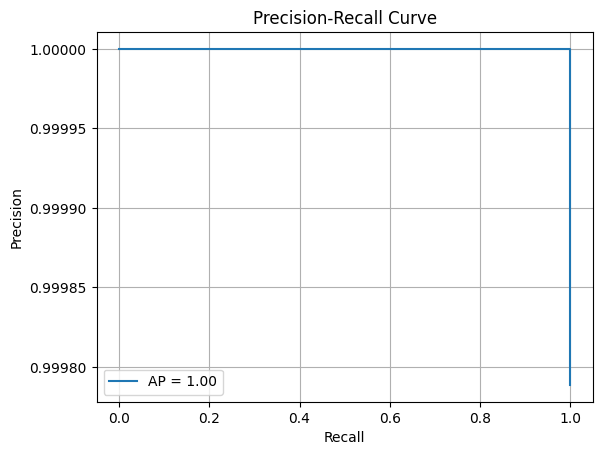

In [ ]:
display_metrics(y_test['attack'], y_pred_xgb, "Attack Prediction",y_proba)


In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["category"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:27:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Category Prediction ---

Classification Report:
   precision    recall  f1-score   support
0   0.999995  0.999849  0.999922  219124.0
1   0.999817  0.999994  0.999906  174590.0
2   0.988372  0.988372  0.988372      86.0
3   0.999848  0.999924  0.999886   13177.0
4   1.000000  1.000000  1.000000      15.0


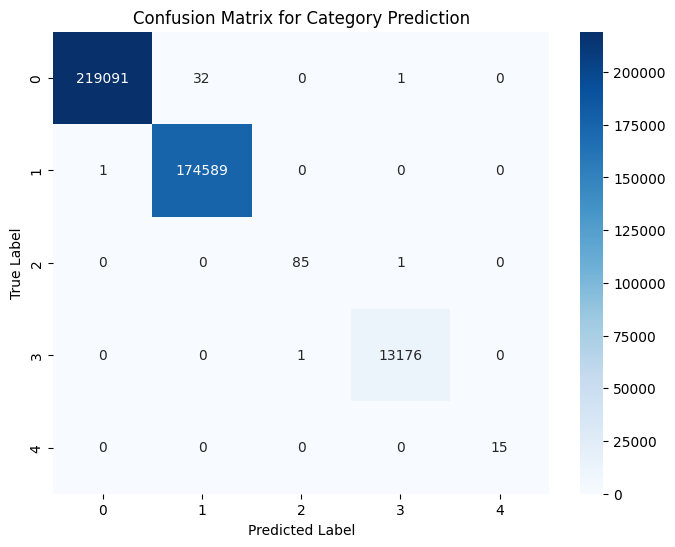


Accuracy: 0.9999
Weighted F1 Score: 0.9999


In [ ]:
display_metrics(y_test['category'], y_pred_xgb, "Category Prediction")

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["subcategory"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:33:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Subcategory Prediction ---

Classification Report:
   precision    recall  f1-score   support
0   1.000000  1.000000  1.000000       1.0
1   1.000000  0.997980  0.998989     495.0
2   1.000000  1.000000  1.000000      14.0
3   1.000000  0.988372  0.994152      86.0
4   0.880909  0.984900  0.930006    2914.0
5   0.995565  0.962292  0.978645   10263.0
6   0.999994  0.999983  0.999989  179025.0
7   0.999986  1.000000  0.999993  214194.0


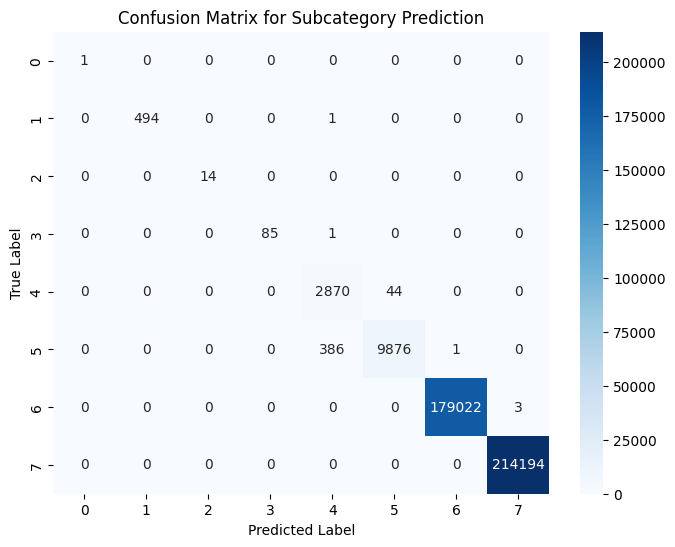


Accuracy: 0.9989
Weighted F1 Score: 0.9989


In [ ]:
display_metrics(y_test['subcategory'], y_pred_xgb, "Subcategory Prediction")

Logistic Regression


In [ ]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["attack"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)

y_proba = logreg_model.predict_proba(X_test)[:, 1]

--- Attack Prediction ---

Classification Report:
   precision    recall  f1-score   support
0   0.345382  1.000000  0.513433      86.0
1   1.000000  0.999599  0.999800  406906.0


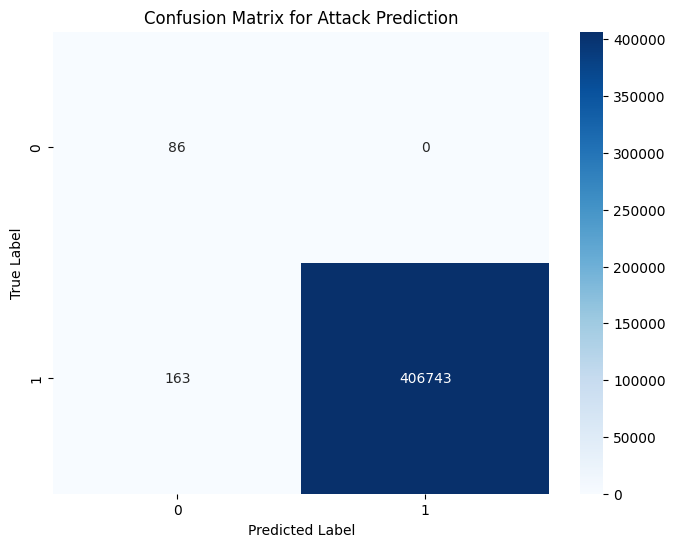


Accuracy: 0.9996
Weighted F1 Score: 0.9997
ROC AUC Score: 1.0000
PR AUC Score: 1.0000


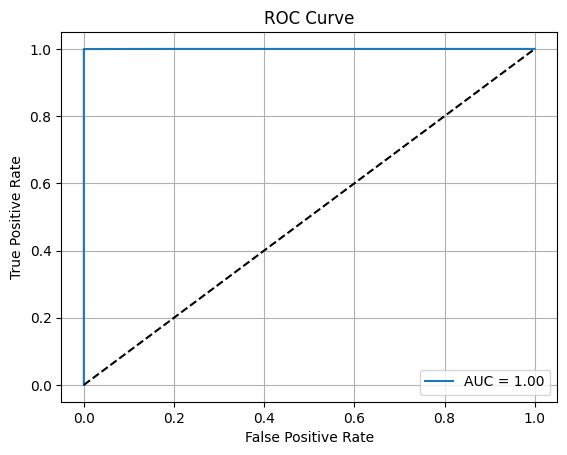

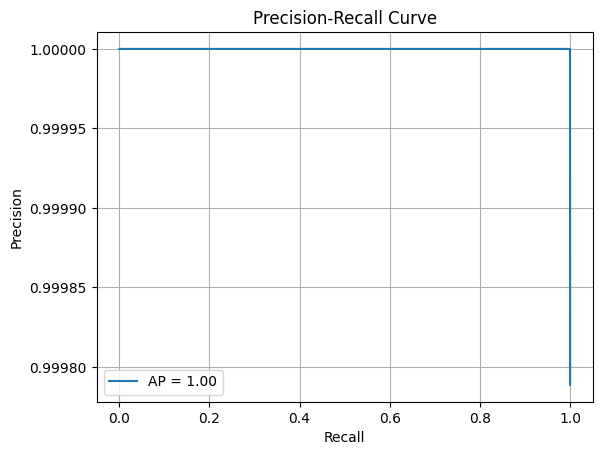

In [ ]:
display_metrics(y_test['attack'], y_pred_logreg, "Attack Prediction",y_proba)


In [ ]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["category"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Category Prediction ---

Classification Report:
   precision    recall  f1-score   support
0   0.950836  0.929118  0.939851  219124.0
1   0.914923  0.939407  0.927003  174590.0
2   0.763636  0.976744  0.857143      86.0
3   0.976685  0.991880  0.984224   13177.0
4   0.126050  1.000000  0.223881      15.0


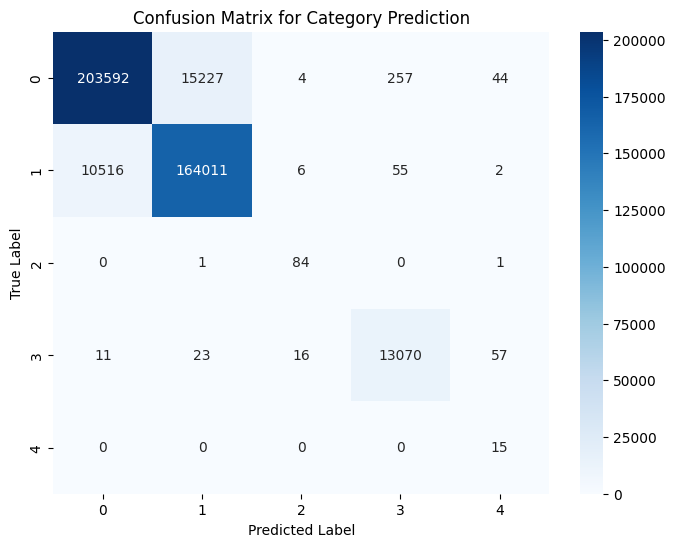


Accuracy: 0.9356
Weighted F1 Score: 0.9357


In [ ]:
display_metrics(y_test['category'], y_pred_logreg, "Category Prediction")

In [ ]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["subcategory"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Subcategory Prediction ---

Classification Report:
   precision    recall  f1-score   support
0   0.026316  1.000000  0.051282       1.0
1   0.711400  0.995960  0.829966     495.0
2   0.203125  0.928571  0.333333      14.0
3   0.885417  0.988372  0.934066      86.0
4   0.375803  0.963624  0.540728    2914.0
5   0.950689  0.544772  0.692641   10263.0
6   0.999787  0.997218  0.998501  179025.0
7   0.999995  0.999944  0.999970  214194.0


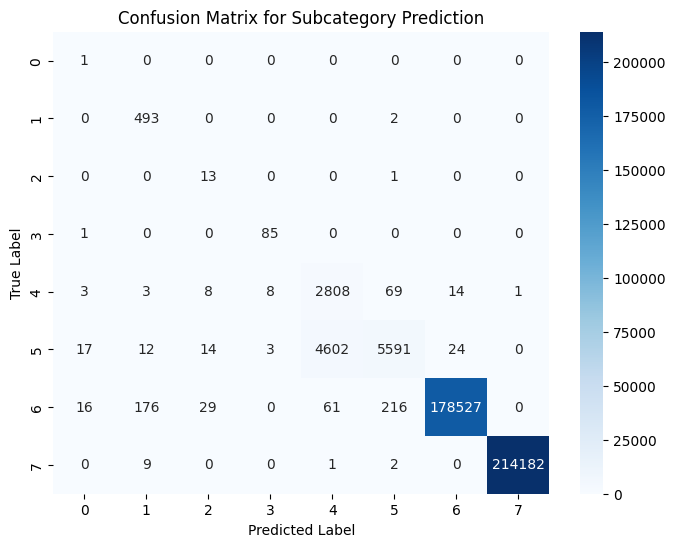


Accuracy: 0.9870
Weighted F1 Score: 0.9880


In [ ]:
display_metrics(y_test['subcategory'], y_pred_logreg, "Subcategory Prediction")

Stacked Model

In [17]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf = RandomForestClassifier(class_weight="balanced")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=200,class_weight="balanced")


stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    n_jobs=-1
)


stacked.fit(X_train, y_train["attack"])



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None,
                                              feature_weights=None,...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced'))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=200,
                                                      multi_class='multinomial'),
                   n_jobs=-1)

--- Attack ---

Classification Report:
   precision    recall  f1-score   support
0   1.000000  0.988372  0.994152      86.0
1   0.999998  1.000000  0.999999  406906.0


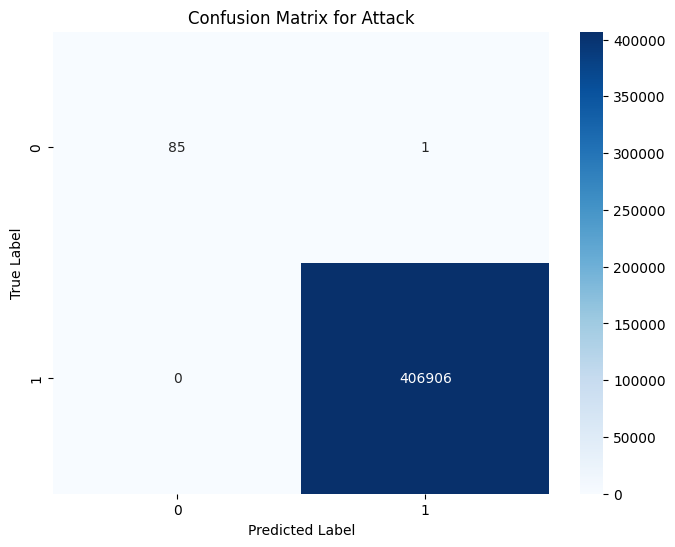


Accuracy: 1.0000
Weighted F1 Score: 1.0000
ROC AUC Score: 1.0000
PR AUC Score: 1.0000


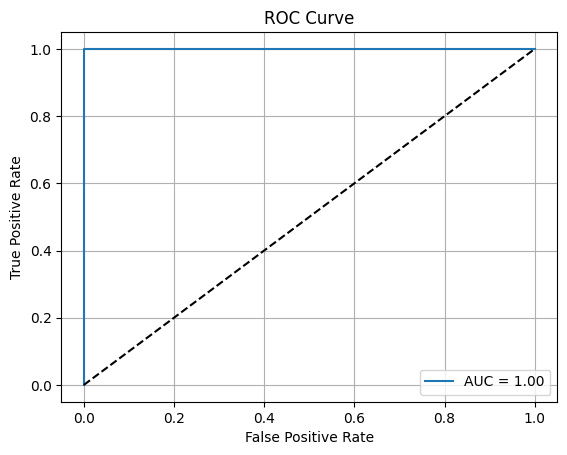

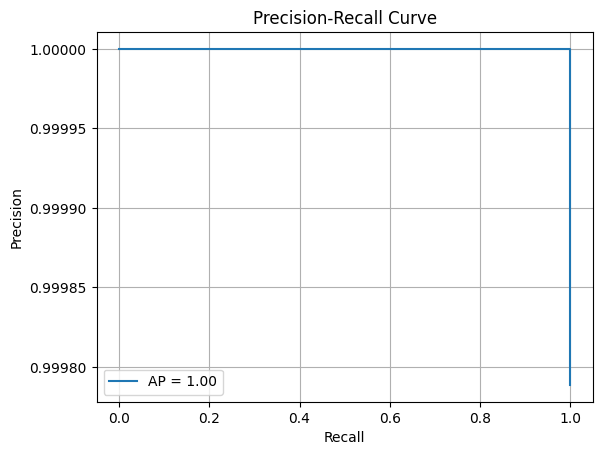

In [18]:
y_pred_attack = stacked.predict(X_test)
y_proba = stacked.predict_proba(X_test)[:, 1]
display_metrics(y_test["attack"], y_pred_attack,"Attack",y_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- category ---

Classification Report:
   precision    recall  f1-score   support
0   0.999991  0.999977  0.999984  219124.0
1   0.999977  0.999989  0.999983  174590.0
2   0.429348  0.918605  0.585185      86.0
3   0.999541  0.991728  0.995619   13177.0
4   0.714286  1.000000  0.833333      15.0


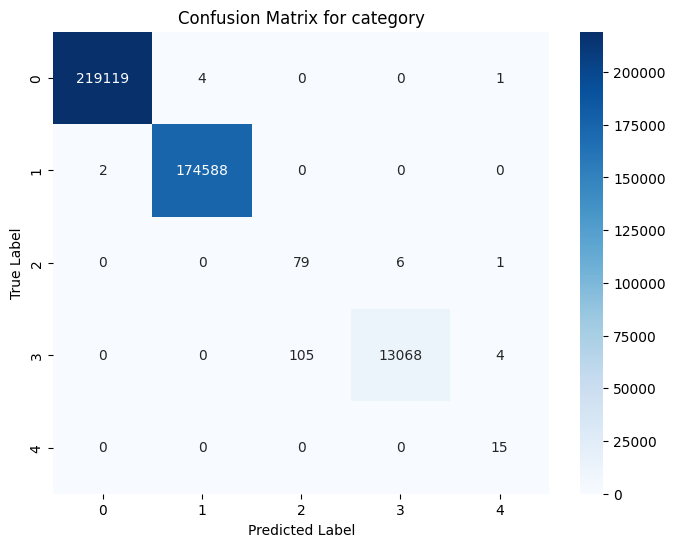


Accuracy: 0.9997
Weighted F1 Score: 0.9997


In [19]:

stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    n_jobs=-1
)
X_cat = np.concatenate([X_train, y_train["attack"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_cat, y_train["category"])


X_cat_test = np.concatenate([X_test, y_pred_attack.reshape(-1, 1)], axis=1)

y_pred_category = stacked.predict(X_cat_test)
display_metrics(y_test["category"], y_pred_category,title="category")



In [20]:
stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    n_jobs=-1
)

X_subcat = np.concatenate([X_cat, y_train["category"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_subcat, y_train["subcategory"])
X_subcat_test = np.concatenate([X_cat_test, y_pred_category.reshape(-1, 1)], axis=1)

y_pred = stacked.predict(X_subcat_test)




/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- Subcategory ---

Classification Report:
   precision    recall  f1-score   support
0   0.250000  1.000000  0.400000       1.0
1   0.995960  0.995960  0.995960     495.0
2   0.823529  1.000000  0.903226      14.0
3   1.000000  0.988372  0.994152      86.0
4   0.990119  0.997255  0.993674    2914.0
5   0.999219  0.996882  0.998049   10263.0
6   1.000000  0.999983  0.999992  179025.0
7   0.999995  1.000000  0.999998  214194.0


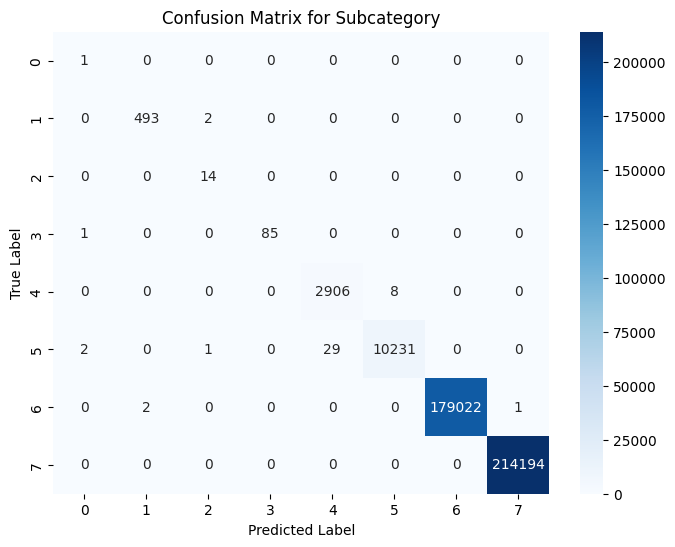


Accuracy: 0.9999
Weighted F1 Score: 0.9999


In [21]:


display_metrics(y_test["subcategory"], y_pred, title="Subcategory")

